<a href="https://colab.research.google.com/github/Francesco146/machine-learning-project/blob/master/Machine_Learning_Pasotto_Marastoni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200
!rm -rf tiny-imagenet-200.zip

--2025-01-13 14:14:26--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-01-13 14:14:26--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  6.10MB/s    in 42s     

2025-01-13 14:15:08 (5.58 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

test  train  val  wnids.txt  words.txt


In [2]:
import os
import pandas as pd


DATA_DIR = 'tiny-imagenet-200'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

val_data = pd.read_csv(f'{VAL_DIR}/val_annotations.txt',
                       sep='\t',
                       header=None,
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

val_data.head()

val_img_dir = os.path.join(VAL_DIR, 'images')

fp = open(os.path.join(VAL_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

val_img_dict = {}
for line in data:
  words = line.split('\t')
  val_img_dict[words[0]] = words[1]
fp.close()

{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

for img, folder in val_img_dict.items():
  new_path = (os.path.join(val_img_dir, folder))
  if not os.path.exists(new_path):
    os.makedirs(new_path)
  if os.path.exists(os.path.join(val_img_dir, img)):
    os.rename(os.path.join(val_img_dir, img), os.path.join(new_path, img))
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for line in data:
  words = line.strip('\n').split('\t')
  class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

{k: class_to_name_dict[k] for k in list(class_to_name_dict)[:20]}

{'n00001740': 'entity',
 'n00001930': 'physical entity',
 'n00002137': 'abstraction',
 'n00002452': 'thing',
 'n00002684': 'object',
 'n00003553': 'whole',
 'n00003993': 'congener',
 'n00004258': 'living thing',
 'n00004475': 'organism',
 'n00005787': 'benthos',
 'n00005930': 'dwarf',
 'n00006024': 'heterotroph',
 'n00006150': 'parent',
 'n00006269': 'life',
 'n00006400': 'biont',
 'n00006484': 'cell',
 'n00007347': 'causal agent',
 'n00007846': 'person',
 'n00015388': 'animal',
 'n00017222': 'plant'}

In [3]:
import torch
import torchvision
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from PIL import Image

class TinyImageNet(Dataset):
  _TRAIN_DIR = TRAIN_DIR
  _VAL_DIR = val_img_dir

  def __init__(self, split = 'train', transform = None):
    super().__init__()
    self.transform = transform

    match split:
      case 'train':
        dataset = ImageFolder(root=self._TRAIN_DIR, transform=transforms.ToTensor())
      case 'val':
        dataset = ImageFolder(root=self._VAL_DIR, transform=transforms.ToTensor())
      case _:
        raise ValueError(f'Invalid split: {split}')

    self.imgs_path = np.array(dataset.imgs)
    self.labels = np.array(dataset.targets)

  def __len__(self):
    return len(self.imgs_path)

  def __getitem__(self, idx):
    img_path, label = self.imgs_path[idx]
    img = Image.open(img_path).convert("RGB")
    if self.transform:
      img = self.transform(img)
    return img, label


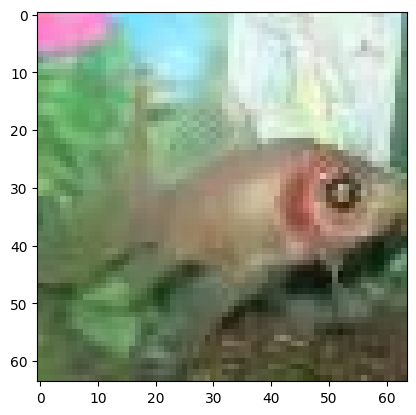

In [4]:
dataset = TinyImageNet(split='train', transform=transforms.ToTensor())

img, label = dataset[0]

import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [29]:
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.RandomCrop(64, padding=4),
    transforms.RandomGrayscale(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_dataset = TinyImageNet(split='train', transform=train_transform)
val_dataset = TinyImageNet(split='val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:

def visualize_samples(dataloader, title, num_samples = 4):
  for images, labels in dataloader:
    for i in range(min(images.shape[0], 4)):
        if num_samples == 0:
          break
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(f"{title}: Class {labels[i]}")
        plt.show()
        num_samples -= 1
    break


visualize_samples(train_dataloader, "Train")
visualize_samples(val_dataloader, "Test")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=50, random_state=42)

max_score = -1
for train_batch, val_batch in zip(train_dataloader, val_dataloader):
  train_images, train_labels = train_batch
  # todo: spiegare il perche
  train_images = train_images.reshape(train_images.shape[0], -1)
  model.fit(train_images, train_labels)

  val_images, val_labels = val_batch
  # todo: spiegare il perche
  val_images = val_images.reshape(val_images.shape[0], -1)
  Y_pred = model.predict(val_images)
  score = accuracy_score(val_labels, Y_pred)
  if score > max_score:
    max_score = score
    print("Risultato:\t" + str(score))
  if score >= 0.8:
    break

print("Risultato finale:\t" + str(score))


Risultato:	0.0
Risultato:	0.015625
Risultato:	0.0625
Risultato:	0.078125
Risultato:	0.09375
Risultato finale:	0.0


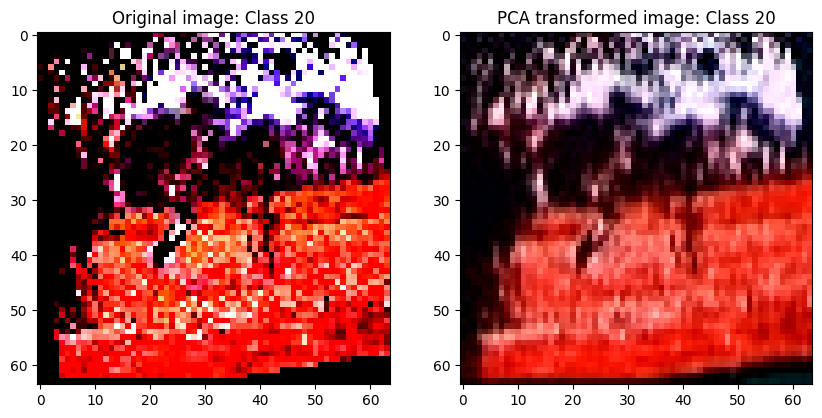

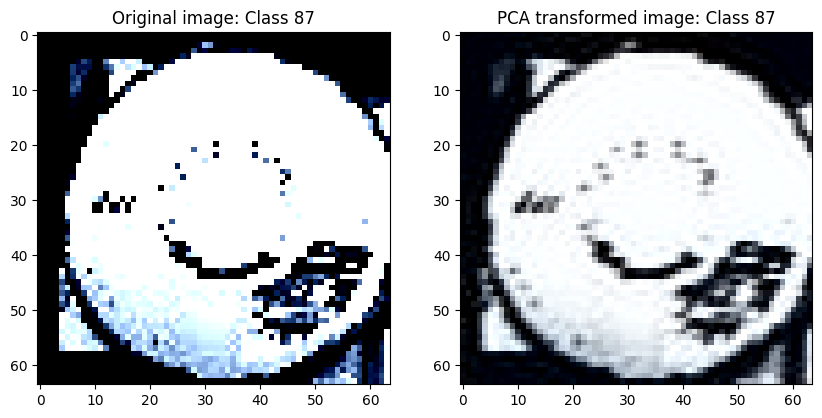

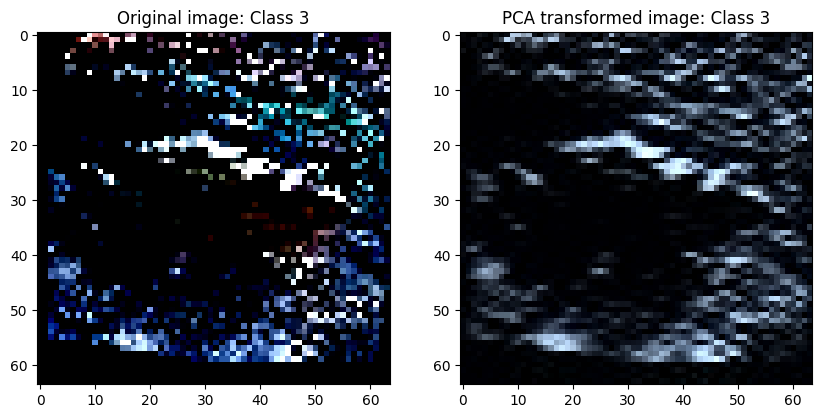

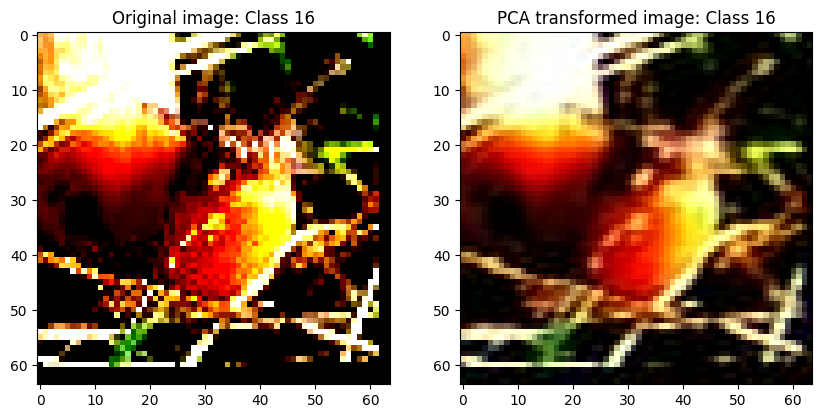

In [64]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d

def pca_transform_patches(img, patch_size, number_of_components):
    # Normalize image
    img = img / 255.0
    h, w, c = img.shape

    # Extract and flatten patches
    patches = extract_patches_2d(img, patch_size)
    patches_flat = patches.reshape(patches.shape[0], -1)

    # Apply PCA
    pca = PCA(n_components=number_of_components)
    patches_pca = pca.fit_transform(patches_flat)
    patches_reconstructed = pca.inverse_transform(patches_pca)
    patches_reconstructed = patches_reconstructed.reshape(patches.shape)

    # Reconstruct image from patches
    img_reconstructed = reconstruct_from_patches_2d(patches_reconstructed, (h, w, c))
    img_reconstructed = np.clip(img_reconstructed, 0, 1)
    return (img_reconstructed * 255).astype(np.uint8)


num_images = 4
patch_size = (8, 8)
number_of_components = 32

for images, labels in train_dataloader:
    for i in range(min(images.shape[0], num_images)):
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        img = (img * 255).astype(np.uint8)
        img_pca = pca_transform_patches(img, patch_size, number_of_components)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Original image: Class {labels[i]}")

        plt.subplot(1, 2, 2)
        plt.imshow(img_pca)
        plt.title(f"PCA transformed image: Class {labels[i]}")

        plt.show()
    break # only the first batch
